Necessary Imports

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import numpy as np


Getting data from data/sentiment_train.csv

In [6]:
data = pd.read_csv('data/sentiment_train.csv')
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  5668 non-null   object
 1   label     5668 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 88.7+ KB
None
                                            sentence  label
0    Ok brokeback mountain is such a horrible movie.      0
1                 Brokeback Mountain was so awesome.      1
2  friday hung out with kelsie and we went and sa...      0
3  I am going to start reading the Harry Potter s...      1
4       Is it just me, or does Harry Potter suck?...      0


Above is how the data looks

Now let us work on it a little bit

1. Make train - test splits.

In [9]:
from sklearn.model_selection import train_test_split

x_tr , x_te , y_tr, y_te = train_test_split(data['sentence'].values,
                                            data['label'].values,
                                            train_size=0.8,
                                            random_state=1)

x_tr, x_va, y_tr, y_va = train_test_split(x_tr,
                                          y_tr,
                                          train_size=0.8,
                                          random_state=1)

print(f'shape of x_train is {x_tr.shape}')
print(f'shape of x_test is {x_te.shape}')
print(f'shape of x_val is {x_va.shape}')
print(f'shape of y_train is {y_tr.shape}')
print(f'shape of y_test is {y_te.shape}')
print(f'shape of y_validation is {y_va.shape}')

shape of x_train is (3627,)
shape of x_test is (1134,)
shape of x_val is (907,)
shape of y_train is (3627,)
shape of y_test is (1134,)
shape of y_validation is (907,)


In [10]:
bert = AutoModel.from_pretrained('bert-base-uncased')

NameError: name 'AutoModel' is not defined

In [12]:
from transformers import AutoModel
bert = AutoModel.from_pretrained('bert-base-uncased')
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

C:\Users\Dushyant S. Udawat\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dushyant S. Udawat\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.tran

Let's see , what should be the padding length. I want to take the median

(array([1340.,  700.,  583.,  443.,  188.,  168.,   99.,   22.,   80.,
           4.]),
 array([ 3. ,  6.7, 10.4, 14.1, 17.8, 21.5, 25.2, 28.9, 32.6, 36.3, 40. ]),
 <BarContainer object of 10 artists>)

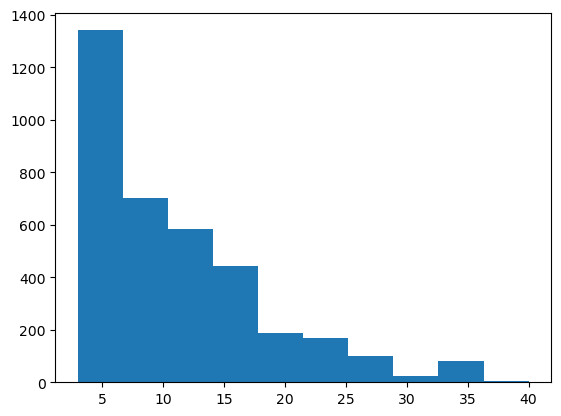

In [15]:
len_of_sentences_in_train_data = [len(i.split()) for i in x_tr]
plt.hist(len_of_sentences_in_train_data)

From looking at the histogram , I think we should take 15 to be the padding.

Alright, Now let's tokenize the data.

In [34]:
pad_len = 15

x_tr_token = tokenizer.batch_encode_plus(
    x_tr.tolist(),
    max_length= pad_len,
    pad_to_max_length = True,
    truncation=True
)

x_va_token = tokenizer.batch_encode_plus(
    x_va.tolist(),
    max_length=pad_len,
    pad_to_max_length = True,
    truncation= True
)

x_te_token = tokenizer.batch_encode_plus(
    x_te.tolist(),
    max_length=pad_len,
    pad_to_max_length = True,
    truncation=True
)

x_tr_seq = torch.tensor(x_tr_token['input_ids'])
x_va_seq = torch.tensor(x_va_token['input_ids'])
x_va_seq = torch.tensor(x_va_token['input_ids'])

C:\Users\Dushyant S. Udawat\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [41]:
print(x_tr_seq)
print(f'the shape of the x_tr_seq is {x_tr_seq.shape}')

tensor([[  101,  1045,  2066,  ...,  1055,  2006,   102],
        [  101,  1045,  2293,  ...,     0,     0,     0],
        [  101,  1045,  5223,  ...,  3791,  1037,   102],
        ...,
        [  101,  4302, 10693,  ...,  2758, 11543,   102],
        [  101,  2029,  2003,  ...,  2480,  1045,   102],
        [  101,  4830, 23765,  ...,     0,     0,     0]])
the shape of the x_tr_seq is torch.Size([3627, 15])


In [31]:
print(x_tr[:3])

print(train_seq[:3])

["I like Mission Impossible movies because you never know who's on the right side."
 'I love Harry Potter..'
 'I hate Harry Potter, that daniel wotshisface needs a fucking slap...']
tensor([[  101,  1045,  2066,  3260,  5263,  5691,  2138,  2017,  2196,  2113,
          2040,  1005,  1055,  2006,   102],
        [  101,  1045,  2293,  4302, 10693,  1012,  1012,   102,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1045,  5223,  4302, 10693,  1010,  2008,  3817, 24185,  3215,
         24158, 12172,  3791,  1037,   102]])


So, as can be seen the tokenizer just makes the sentence into dictionary indexes. It is nothing special , there is not machine learning here. However, we should remember that the dictionary indexes here are related to their corresponding embeddigns in the trained bert model.

# Defining the model

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_arch(nn.Module):
    def __init__(self, bert):
        super(BERT_arch, self).__init__()
        self.bert = bert

        # adding a dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2
        self. fc2 = nn.Linear(512, 2)

        # softmax activaton
        self.softmax = nn.LogSoftmax(dim =1 )

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        x = self.softmax(x)

        return x




In [ ]:
model = BERT_arch(bert)
optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-5)  # learning rate
